# 🧭 Exploratory Data Analysis (EDA) et Pré-traitement du jeu de données CVE

Voici un guide pratique, ciblé et prêt à l’emploi pour l’**EDA (Exploratory Data Analysis)** et le **pré-traitement** de notre jeu de données de vulnérabilités (CVE).  
Ce notebook couvre : les **objectifs de l’EDA**, les **contrôles qualité**, les **étapes de nettoyage**, le **feature engineering** pour l’analytics ou le machine learning, ainsi que des **idées de visualisations**.  

---

## 1️⃣ Objectifs de l’EDA (ce qu’on cherche à observer)

- **Qualité des données** : doublons, valeurs manquantes, formats incohérents (dates, scores).
- **Distribution des vulnérabilités** : par `cvss_score`, `cvss_severity`, `vendor`, `product`, `category`.
- **Temporalité** : tendances de publication/modification, fréquence par jour, semaine, mois.
- **Corrélations** : entre score CVSS et exploitability/impact ; entre attack_vector et severity.
- **Text mining** : repérage de thèmes récurrents dans `title` et `description` (RCE, Path Traversal, etc.).
- **Création de flags analytiques** : `is_remote`, `has_exploit`, `patched`, `is_high_risk`, etc.

---

## 2️⃣ Contrôles qualité rapides

- Vérifier les **doublons** sur `cve_id`.
- Vérifier les **dates parseables** (`published_date`, `last_modified`).
- Vérifier que `cvss_score` est **numérique** et compris entre **0 et 10**.
- Uniformiser la casse et les valeurs catégorielles (`Network` → `network`).
- Identifier et séparer les **champs multi-valeurs** (`vendors`, `products`) à *explode*.

---

## 3️⃣ Pré-traitement détaillé (pipeline recommandé)

### a) Chargement et nettoyage de base
- Lecture du CSV avec `dtype=str` pour éviter les conversions automatiques.
- Suppression des espaces et normalisation en minuscules.
- Conversion des types : `float` pour `cvss_score`, `datetime` pour les dates.

### b) Dates
- Standardiser `published_date` et `last_modified` (UTC ou fuseau local).
- Extraire des variables temporelles : `year`, `month`, `week`, `day_of_week`, `age_days = today - published_date`.

### c) CVSS
- Convertir `cvss_score` en float et créer `severity_label` si absent (Low < 4 ; Medium 4–7 ; High ≥ 7).
- **Parser** `cvss_vector` (ex. : `CVSS:3.1/AV:N/AC:L/PR:N/UI:R/S:U/C:H/I:H/A:H`) pour extraire les métriques AV, AC, PR, UI, S, C, I, A.
  - Si aucune librairie externe n’est utilisée : découpage par `split('/')` et `key:value`.

### d) Colonnes booléennes / flags
- `is_remote = attack_vector.str.contains('Network', case=False)`
- `has_exploit = source_from_table.str.contains('exploit', case=False)`
- `is_patched = description` contient « fixed » / « version » → extraction de `fixed_version` si possible.

### e) Multi-valeurs
- `affected_vendors` et `affected_products` souvent séparés par `,` ou `;` → normaliser puis *explode* pour analyses par produit/vendor.

### f) Texte (`title`, `description`)
- Nettoyage (minuscule, suppression HTML/URL/ponctuation), tokenisation, stop-words, lemmatisation (spaCy / NLTK).
- Représentation TF-IDF ou embeddings (Sentence-Transformers) pour *topic modeling*.

### g) Valeurs manquantes
- Imputation : médiane du `cvss_score` par `category` ; label `unknown` pour catégories manquantes.
- Conserver un masque des valeurs imputées (utile pour suivi qualité).

### h) Encodage pour ML
- Encodage One-Hot ou Target-Encoding pour les variables catégorielles (`attack_vector`, `privileges_required`, `user_interaction`, `scope`).
- Normalisation des variables continues (`cvss_score`, `exploitability_score`, `impact_score`) via `StandardScaler`.

---

## 4️⃣ Features utiles à créer (exemples)

- `severity_label` → Low / Medium / High / Critical  
- `vector_av`, `vector_ac`, `vector_pr`, `vector_ui`, `vector_scope`, `vector_c`, `vector_i`, `vector_a`  
- `is_remote` → bool  
- `days_since_published`  
- `num_vendors`, `num_products`  
- `description_len`, `title_len`  
- `has_patch_info` → bool  
- `exploitability_normalized` (échelle 0–1)

---

## 5️⃣ Visualisations recommandées (quick wins)

- Histogramme du `cvss_score`
- Barplot : top 20 vendors / products (après *explode*)
- Time Series : nombre de CVE publiés par semaine ou mois
- Heatmap des corrélations (`cvss_score`, `exploitability_score`, `impact_score`)
- Wordcloud / TF-IDF : top tokens dans `description` par `severity`
- Barres empilées : `attack_vector` vs `severity`

---

🧩 **Étape suivante** : importer les bibliothèques nécessaires (Pandas, NumPy, Matplotlib, Seaborn, etc.) et charger le dataset brut.


In [8]:
# ============================================================
# 🧩 Bloc 2 : Importation des bibliothèques et configuration
# ============================================================

# --- Manipulation et analyse de données
import pandas as pd
import numpy as np

# --- Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# --- Traitement du texte
import re
import string

# --- Pré-traitement et machine learning utils
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

# --- Date et temps
from datetime import datetime, timedelta

# --- Options d’affichage pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)
pd.set_option('display.width', 120)
pd.set_option('display.float_format', '{:.2f}'.format)

# --- Style des graphiques
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 5)
plt.rcParams['axes.titlesize'] = 13
plt.rcParams['axes.labelsize'] = 11

In [9]:
# ============================================================
# 🧩 Bloc 3 : Chargement et inspection initiale du dataset
# ============================================================

# --- 1️⃣ Charger le dataset brut
file_path = "output/cve_detailed_raw.csv" 
df = pd.read_csv(file_path, dtype=str, encoding='utf-8', low_memory=False)

print("✅ Dataset chargé avec succès !")
print(f"➡️  Dimensions du dataset : {df.shape[0]} lignes × {df.shape[1]} colonnes\n")

# --- 2️⃣ Aperçu des premières lignes
display(df.head(5))

# --- 3️⃣ Informations générales sur les colonnes
print("\n🧱 Informations sur les types de colonnes :")
df.info()

# --- 4️⃣ Aperçu statistique rapide (sur colonnes numériques si déjà existantes)
print("\n📊 Aperçu statistique (toutes les colonnes) :")
display(df.describe(include='all'))  # 'all' inclut object et number

# --- 5️⃣ Vérifier les valeurs manquantes
print("\n🚨 Valeurs manquantes par colonne :")
missing_values = df.isna().sum().sort_values(ascending=False)
display(missing_values[missing_values > 0])

# --- 6️⃣ Vérifier les doublons sur l'identifiant CVE
if "cve_id" in df.columns:
    duplicates = df.duplicated(subset="cve_id").sum()
    print(f"\n🧩 Doublons trouvés sur cve_id : {duplicates}")
else:
    print("\n⚠️  Colonne 'cve_id' absente du dataset — à vérifier.")

# --- 7️⃣ Aperçu des valeurs uniques (pour catégories principales)
cols_to_check = ['cvss_severity', 'cvss_version', 'attack_vector', 'category']
for col in cols_to_check:
    if col in df.columns:
        print(f"\n🔹 Valeurs uniques pour '{col}':")
        print(df[col].dropna().unique()[:10])


✅ Dataset chargé avec succès !
➡️  Dimensions du dataset : 500 lignes × 26 colonnes



,cve_id,title,description,cvss_score,cvss_severity,cvss_version,cvss_vector,exploitability_score,impact_score,published_date,last_modified,remotely_exploit,source,source_from_table,category,affected_vendors,affected_products,attack_vector,attack_complexity,privileges_required,user_interaction,scope,confidentiality_impact,integrity_impact,availability_impact,url
0,CVE-2025-61590,Cursor is vulnerable to RCE via .code-workspac...,The following products are affected byCVE-2025...,7.5,HIGH,CVSS 3.1,CVSS:3.1/AV:N/AC:H/PR:L/UI:N/S:U/C:H/I:H/A:H,1.6,5.9,"Oct. 3, 2025, 5:15 p.m.","Oct. 6, 2025, 2:56 p.m.",Yes !,[email protected],[email protected],Misconfiguration,Anysphere,cursor,Network,High,Low,NaN,Unchanged,High,High,High,https://cvefeed.io/vuln/detail/CVE-2025-61590
1,CVE-2025-61591,Cursor CLI's Cursor Agent MCP OAuth2 Communica...,Cursor is a code editor built for programming ...,8.8,HIGH,CVSS 3.1,CVSS:3.1/AV:N/AC:L/PR:N/UI:R/S:U/C:H/I:H/A:H,2.8,5.9,"Oct. 3, 2025, 5:15 p.m.","Oct. 6, 2025, 2:56 p.m.",Yes !,[email protected],[email protected],Authentication,Anysphere,cursor,Network,Low,NaN,Required,Unchanged,High,High,High,https://cvefeed.io/vuln/detail/CVE-2025-61591
2,CVE-2025-33034,Qsync Central,A path traversal vulnerability has been report...,6.5,MEDIUM,CVSS 3.1,CVSS:4.0/AV:N/AC:L/AT:N/PR:L/UI:N/VC:L/VI:N/VA...,NaN,NaN,"Oct. 3, 2025, 6:15 p.m.","Oct. 7, 2025, 3:04 p.m.",Yes !,[email protected],[email protected],Path Traversal,Qnap,qsync_central,Network,Low,Low,NaN,Unchanged,High,NaN,NaN,https://cvefeed.io/vuln/detail/CVE-2025-33034
3,CVE-2025-33039,Qsync Central,An allocation of resources without limits or t...,7.1,HIGH,CVSS 4.0,CVSS:4.0/AV:N/AC:L/AT:N/PR:L/UI:N/VC:N/VI:N/VA...,NaN,NaN,"Oct. 3, 2025, 6:15 p.m.","Oct. 7, 2025, 3:01 p.m.",Yes !,[email protected],[email protected],Denial of Service,Qnap,qsync_central,Network,Low,Low,NaN,Unchanged,NaN,NaN,High,https://cvefeed.io/vuln/detail/CVE-2025-33039
4,CVE-2025-33040,Qsync Central,An allocation of resources without limits or t...,7.1,HIGH,CVSS 4.0,CVSS:4.0/AV:N/AC:L/AT:N/PR:L/UI:N/VC:N/VI:N/VA...,NaN,NaN,"Oct. 3, 2025, 6:15 p.m.","Oct. 7, 2025, 3 p.m.",Yes !,[email protected],[email protected],Denial of Service,Qnap,qsync_central,Network,Low,Low,NaN,Unchanged,NaN,NaN,High,https://cvefeed.io/vuln/detail/CVE-2025-33040



🧱 Informations sur les types de colonnes :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 26 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   cve_id                  500 non-null    object
 1   title                   494 non-null    object
 2   description             500 non-null    object
 3   cvss_score              500 non-null    object
 4   cvss_severity           464 non-null    object
 5   cvss_version            464 non-null    object
 6   cvss_vector             464 non-null    object
 7   exploitability_score    184 non-null    object
 8   impact_score            184 non-null    object
 9   published_date          500 non-null    object
 10  last_modified           500 non-null    object
 11  remotely_exploit        500 non-null    object
 12  source                  500 non-null    object
 13  source_from_table       464 non-null    object
 14  category      

,cve_id,title,description,cvss_score,cvss_severity,cvss_version,cvss_vector,exploitability_score,impact_score,published_date,last_modified,remotely_exploit,source,source_from_table,category,affected_vendors,affected_products,attack_vector,attack_complexity,privileges_required,user_interaction,scope,confidentiality_impact,integrity_impact,availability_impact,url
count,500,494,500,500,464,464,464,184,184,500,500,500,500,464,484,488,488,464,464,283,107,422,335,318,289,500
unique,500,439,468,65,4,4,173,19,14,106,120,2,8,8,15,108,135,4,2,2,3,2,2,2,2,500
top,CVE-2025-11166,"QTS, QuTS hero",A NULL pointer dereference vulnerability has b...,9.8,MEDIUM,CVSS 3.1,CVSS:4.0/AV:N/AC:L/AT:N/PR:L/UI:N/VC:L/VI:L/VA...,2.8,5.9,"Oct. 3, 2025, 7:15 p.m.","Oct. 8, 2025, 7:38 p.m.",Yes !,[email protected],[email protected],Injection,CVSS 3.1,MEDIUM; MEDIUM,Network,Low,Low,Required,Unchanged,High,High,High,https://cvefeed.io/vuln/detail/CVE-2025-11166
freq,1,24,17,54,208,293,45,52,43,43,139,398,466,413,138,46,41,398,423,210,52,360,207,189,218,1



🚨 Valeurs manquantes par colonne :


user_interaction          393
exploitability_score      316
impact_score              316
privileges_required       217
availability_impact       211
integrity_impact          182
confidentiality_impact    165
scope                      78
cvss_vector                36
cvss_severity              36
attack_complexity          36
cvss_version               36
source_from_table          36
attack_vector              36
category                   16
affected_vendors           12
affected_products          12
title                       6
dtype: int64


🧩 Doublons trouvés sur cve_id : 0

🔹 Valeurs uniques pour 'cvss_severity':
['HIGH' 'MEDIUM' 'CRITICAL' 'LOW']

🔹 Valeurs uniques pour 'cvss_version':
['CVSS 3.1' 'CVSS 4.0' 'CVSS 2.0' 'CVSS 3.0']

🔹 Valeurs uniques pour 'attack_vector':
['Network' 'Local' 'Physical' 'Adjacent']

🔹 Valeurs uniques pour 'category':
['Misconfiguration' 'Authentication' 'Path Traversal' 'Denial of Service'
 'Injection' 'Cross-Site Scripting' 'Memory Corruption' 'Authorization'
 'Supply Chain' 'Server-Side Request Forgery']


In [12]:
# ============================================================
# 🧩 Bloc 4 : Nettoyage de base et conversions de types
# ============================================================

# --- 1️⃣ Nettoyage des espaces et normalisation en minuscules (pour toutes les colonnes string)
print("🧹 Nettoyage des chaînes de caractères...")
string_columns = df.select_dtypes(include=['object']).columns
for col in string_columns:
    if col in df.columns:
        df[col] = df[col].astype(str).str.strip().str.lower().replace('nan', np.nan)

print("✅ Normalisation appliquée.")

# --- 2️⃣ Conversion des colonnes numériques (gestion des erreurs avec coerce)
print("\n🔢 Conversion des scores en float...")
numeric_cols = ['cvss_score', 'exploitability_score', 'impact_score']
for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
        print(f"   → {col} : min={df[col].min():.2f}, max={df[col].max():.2f}, NaN={df[col].isna().sum()}")

# Vérification rapide : cvss_score doit être entre 0 et 10
if 'cvss_score' in df.columns:
    invalid_scores = df[(df['cvss_score'] < 0) | (df['cvss_score'] > 10)]
    if not invalid_scores.empty:
        print(f"⚠️  {len(invalid_scores)} scores CVSS invalides détectés (hors [0,10]).")
    else:
        print("✅ Scores CVSS dans la plage valide.")

# --- 3️⃣ Conversion et extraction des dates
print("\n📅 Conversion des dates...")
date_cols = ['published_date', 'last_modified']
for col in date_cols:
    if col in df.columns:
        # Format observé : "oct. 3, 2025, 5:15 p.m." → %b. %d, %Y, %I:%M %p (mais lowercase après nettoyage)
        df[col] = pd.to_datetime(df[col], errors='coerce', format='%b. %d, %Y, %I:%M %p')
        print(f"   → {col} : {df[col].min()} à {df[col].max()}, NaN={df[col].isna().sum()}")

# Ajout de features temporelles (basé sur la date actuelle : 2025-10-11)
today = pd.to_datetime('2025-10-11')
if 'published_date' in df.columns:
    df['days_since_published'] = (today - df['published_date']).dt.days
    df['published_year'] = df['published_date'].dt.year
    df['published_month'] = df['published_date'].dt.month
    df['published_week'] = df['published_date'].dt.isocalendar().week
    print("   → Features temporelles ajoutées (days_since_published, year, month, week).")

# --- 4️⃣ Création de severity_label si cvss_severity manquant ou incohérent
print("\n🏷️  Création/alignement de severity_label...")
if 'cvss_severity' in df.columns:
    # Mapper les valeurs existantes pour uniformité
    severity_map = {
        'low': 'low', 'medium': 'medium', 'high': 'high', 'critical': 'critical',
        'none': 'none'  # Si présent
    }
    df['severity_label'] = df['cvss_severity'].map(severity_map).fillna('unknown')
else:
    # Créer à partir de cvss_score si absent
    def get_severity(score):
        if pd.isna(score):
            return 'unknown'
        elif score < 4.0:
            return 'low'
        elif score < 7.0:
            return 'medium'
        elif score < 9.0:
            return 'high'
        else:
            return 'critical'
    df['severity_label'] = df['cvss_score'].apply(get_severity)

print(f"   → Distribution de severity_label : {df['severity_label'].value_counts().to_dict()}")

# --- 5️⃣ Aperçu après nettoyage
print("\n🔍 Aperçu des types après conversions :")
df.info()

print("\n📊 Stats mises à jour (numériques) :")
display(df[['cvss_score', 'exploitability_score', 'impact_score', 'days_since_published']].describe())

print("\n✅ Bloc 4 terminé ! Prêt pour le parsing CVSS et flags booléens.")

🧹 Nettoyage des chaînes de caractères...
✅ Normalisation appliquée.

🔢 Conversion des scores en float...
   → cvss_score : min=0.00, max=10.00, NaN=0
   → exploitability_score : min=0.30, max=3.90, NaN=316
   → impact_score : min=1.40, max=6.00, NaN=316
✅ Scores CVSS dans la plage valide.

📅 Conversion des dates...
   → published_date : NaT à NaT, NaN=500
   → last_modified : NaT à NaT, NaN=500
   → Features temporelles ajoutées (days_since_published, year, month, week).

🏷️  Création/alignement de severity_label...
   → Distribution de severity_label : {'medium': 208, 'high': 165, 'critical': 76, 'unknown': 36, 'low': 15}

🔍 Aperçu des types après conversions :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 39 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   cve_id                  500 non-null    object        
 1   title                   494 non-null   

,cvss_score,exploitability_score,impact_score,days_since_published
count,500.00,184.00,184.00,0.00
mean,6.62,2.63,3.89,NaN
std,2.60,1.04,1.70,NaN
min,0.00,0.30,1.40,NaN
25%,5.30,1.80,2.50,NaN
50%,6.70,2.80,3.60,NaN
75%,8.80,3.90,5.90,NaN
max,10.00,3.90,6.00,NaN



✅ Bloc 4 terminé ! Prêt pour le parsing CVSS et flags booléens.


In [13]:
# ============================================================
# 🧩 Bloc 5 : Parsing CVSS et création de flags booléens
# ============================================================

# --- 1️⃣ Parser du vecteur CVSS
print("🔍 Parsing du vecteur CVSS...")
def parse_cvss_vector(vector_str):
    """
    Parse une chaîne CVSS (ex: 'CVSS:3.1/AV:N/AC:L/PR:N/UI:R/S:U/C:H/I:H/A:H')
    et retourne un dict avec les métriques extraites.
    """
    if pd.isna(vector_str) or not isinstance(vector_str, str):
        return {key: np.nan for key in ['av', 'ac', 'pr', 'ui', 's', 'c', 'i', 'a']}
    
    # Ignorer le préfixe 'CVSS:3.1/' et splitter par '/'
    parts = vector_str.split('/')[1:]  # Skip 'CVSS:3.1'
    metrics = {}
    for part in parts:
        if ':' in part:
            key, value = part.split(':')
            metrics[key.upper()] = value.upper()
    
    # Mapper vers colonnes standard
    mapping = {
        'AV': 'attack_vector', 'AC': 'attack_complexity', 'PR': 'privileges_required',
        'UI': 'user_interaction', 'S': 'scope', 'C': 'confidentiality_impact',
        'I': 'integrity_impact', 'A': 'availability_impact'
    }
    result = {}
    for cvss_key, df_col in mapping.items():
        result[df_col] = metrics.get(cvss_key, np.nan)
    
    return result

# Appliquer le parsing si cvss_vector existe
if 'cvss_vector' in df.columns:
    parsed = df['cvss_vector'].apply(parse_cvss_vector)
    parsed_df = pd.DataFrame(parsed.tolist())
    
    # Fusionner avec df (gérer les colonnes existantes en les mettant à jour)
    for col in parsed_df.columns:
        if col in df.columns:
            # Priorité au parsing si nouveau ou NaN
            mask = df[col].isna()
            df.loc[mask, col] = parsed_df.loc[mask, col]
        else:
            df[col] = parsed_df[col]
    
    print("   → Métriques CVSS parsées et intégrées (AV, AC, PR, UI, S, C, I, A).")
    print(f"   → Exemple pour la première ligne : {parsed.iloc[0]}")
else:
    print("⚠️  Colonne 'cvss_vector' absente — parsing CVSS sauté.")

# --- 2️⃣ Création des flags booléens
print("\n🚩 Création des flags analytiques...")

# is_remote : basé sur attack_vector == 'network'
if 'attack_vector' in df.columns:
    df['is_remote'] = (df['attack_vector'] == 'network').astype(bool)
    print(f"   → is_remote : {df['is_remote'].sum()} / {len(df)} vulnérabilités distantes.")

# has_exploit : recherche dans source_from_table ou description
if 'source_from_table' in df.columns or 'description' in df.columns:
    search_cols = ['source_from_table', 'description']
    has_exploit_mask = pd.Series([False] * len(df), index=df.index)
    for col in search_cols:
        if col in df.columns:
            has_exploit_mask |= df[col].astype(str).str.contains('exploit|proof|poc', case=False, na=False)
    df['has_exploit'] = has_exploit_mask
    print(f"   → has_exploit : {df['has_exploit'].sum()} / {len(df)} avec indicateur d'exploit.")

# is_high_risk : severity high ou critical, ou cvss_score >= 7
df['is_high_risk'] = (
    (df['severity_label'].isin(['high', 'critical'])) | 
    (df['cvss_score'] >= 7.0)
).fillna(False).astype(bool)
print(f"   → is_high_risk : {df['is_high_risk'].sum()} / {len(df)} vulnérabilités à haut risque.")

# has_patch_info : recherche de mots-clés dans description
if 'description' in df.columns:
    df['has_patch_info'] = df['description'].astype(str).str.contains('fixed|patched|version|update', case=False, na=False)
    print(f"   → has_patch_info : {df['has_patch_info'].sum()} / {len(df)} avec info de patch.")

# --- 3️⃣ Gestion des multi-valeurs (affected_vendors et affected_products)
print("\n🔄 Normalisation et explosion des multi-valeurs...")

multi_cols = ['affected_vendors', 'affected_products']
for col in multi_cols:
    if col in df.columns:
        # Remplacer séparateurs courants par virgule et splitter
        df[col] = df[col].astype(str).str.replace(';', ',').str.replace(' | ', ',').str.strip()
        # Compter le nombre pour feature
        df[f'num_{col}'] = df[col].str.count(',') + 1  # +1 pour l'élément principal
        print(f"   → {col} : moyenne {df[f'num_{col}'].mean():.1f} valeurs par CVE.")

# Optionnel : créer un df explosé pour analyses ultérieures (non assigné à df principal)
df_exploded_vendors = None
if 'affected_vendors' in df.columns:
    df_temp = df.copy()
    df_temp['affected_vendors'] = df_temp['affected_vendors'].str.split(',')
    df_exploded_vendors = df_temp.explode('affected_vendors').dropna(subset=['affected_vendors'])
    df_exploded_vendors['affected_vendors'] = df_exploded_vendors['affected_vendors'].str.strip()
    print(f"   → df_exploded_vendors prêt : {len(df_exploded_vendors)} lignes après explosion.")

# --- 4️⃣ Aperçu après ajouts
print("\n🔍 Nouvelles colonnes ajoutées :")
new_cols = ['is_remote', 'has_exploit', 'is_high_risk', 'has_patch_info', 'days_since_published', 'severity_label']
for col in new_cols:
    if col in df.columns:
        if df[col].dtype == 'bool':
            print(f"   → {col} : {df[col].sum()} True / {len(df)}")
        else:
            print(f"   → {col} : {df[col].nunique()} uniques")

print("\n📊 Distribution des flags booléens :")
bool_cols = df.select_dtypes(include=['bool']).columns
if len(bool_cols) > 0:
    display(df[bool_cols].sum().to_frame('Count True'))

print("\n✅ Bloc 5 terminé ! Prêt pour le nettoyage texte et imputation des manquants.")

🔍 Parsing du vecteur CVSS...
   → Métriques CVSS parsées et intégrées (AV, AC, PR, UI, S, C, I, A).
   → Exemple pour la première ligne : {'attack_vector': 'N', 'attack_complexity': 'H', 'privileges_required': 'L', 'user_interaction': 'N', 'scope': 'U', 'confidentiality_impact': 'H', 'integrity_impact': 'H', 'availability_impact': 'H'}

🚩 Création des flags analytiques...
   → is_remote : 398 / 500 vulnérabilités distantes.
   → has_exploit : 192 / 500 avec indicateur d'exploit.
   → is_high_risk : 241 / 500 vulnérabilités à haut risque.
   → has_patch_info : 317 / 500 avec info de patch.

🔄 Normalisation et explosion des multi-valeurs...
   → affected_vendors : moyenne 1.5 valeurs par CVE.
   → affected_products : moyenne 1.5 valeurs par CVE.
   → df_exploded_vendors prêt : 750 lignes après explosion.

🔍 Nouvelles colonnes ajoutées :
   → is_remote : 398 True / 500
   → has_exploit : 192 True / 500
   → is_high_risk : 241 True / 500
   → has_patch_info : 317 True / 500
   → days_since

,Count True
is_remote,398
has_exploit,192
is_high_risk,241
has_patch_info,317



✅ Bloc 5 terminé ! Prêt pour le nettoyage texte et imputation des manquants.


In [14]:
# ============================================================
# 🧩 Bloc 6 : Nettoyage texte et imputation des valeurs manquantes
# ============================================================

# --- 1️⃣ Nettoyage du texte (title et description)
print("🧹 Nettoyage des colonnes texte...")
def clean_text(text):
    """
    Nettoie une chaîne texte : minuscules (déjà fait), suppression URL, HTML, ponctuation, chiffres.
    Tokenisation basique et suppression stop-words (via NLTK si importé, sinon simple).
    """
    if pd.isna(text) or not isinstance(text, str):
        return ''
    
    # Suppression URL
    text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text)
    
    # Suppression HTML basique
    text = re.sub(r'<[^>]+>', '', text)
    
    # Ponctuation et chiffres
    text = re.sub(r'[%s]' % re.escape(string.punctuation), ' ', text)
    text = re.sub(r'\d+', '', text)
    
    # Minuscules et strip multiples espaces
    text = ' '.join(text.lower().split())
    
    return text

# Appliquer si colonnes existent
text_cols = ['title', 'description']
for col in text_cols:
    if col in df.columns:
        df[f'{col}_clean'] = df[col].apply(clean_text)
        print(f"   → {col}_clean créée : {df[f'{col}_clean'].str.len().mean():.1f} chars moyens.")

# Optionnel : Ajout de features longueur texte
for col in text_cols:
    if col in df.columns:
        df[f'{col}_len'] = df[col].astype(str).str.len()
        print(f"   → {col}_len : moyenne {df[f'{col}_len'].mean():.1f} caractères.")

# --- 2️⃣ Imputation des valeurs manquantes
print("\n🔧 Imputation des manquants...")

# Garder trace des imputations originales
imputation_mask = df.isna().copy()

# Pour cvss_score : médiane par category si category existe
if 'cvss_score' in df.columns and 'category' in df.columns:
    median_by_cat = df.groupby('category')['cvss_score'].median()
    df['cvss_score'] = df.apply(
        lambda row: median_by_cat.get(row['category'], df['cvss_score'].median()) if pd.isna(row['cvss_score']) else row['cvss_score'],
        axis=1
    )
    print(f"   → cvss_score : {imputation_mask['cvss_score'].sum()} imputés par médiane/category.")

# Pour colonnes catégorielles : 'unknown'
cat_cols = ['cvss_severity', 'attack_vector', 'attack_complexity', 'privileges_required', 
            'user_interaction', 'scope', 'confidentiality_impact', 'integrity_impact', 'availability_impact']
for col in cat_cols:
    if col in df.columns:
        df[col] = df[col].fillna('unknown')
        print(f"   → {col} : {imputation_mask[col].sum()} remplacés par 'unknown'.")

# Pour dates : published_date à min du dataset si NaN (conservateur)
if 'published_date' in df.columns:
    min_date = df['published_date'].min()
    df['published_date'] = df['published_date'].fillna(min_date)
    print(f"   → published_date : {imputation_mask['published_date'].sum()} remplacés par date min.")

# Pour multi-valeurs : 'unknown' si vide
for col in ['affected_vendors', 'affected_products']:
    if col in df.columns:
        df[col] = df[col].fillna('unknown')
        print(f"   → {col} : {imputation_mask[col].sum()} remplacés par 'unknown'.")

# Vérification finale des manquants
print("\n🚨 Manquants restants :")
remaining_missing = df.isna().sum().sort_values(ascending=False)
display(remaining_missing[remaining_missing > 0])

# --- 3️⃣ Représentation TF-IDF simple (exemple pour description_clean)
print("\n📝 Exemple TF-IDF sur description_clean...")
if 'description_clean' in df.columns and len(df) > 0:
    tfidf = TfidfVectorizer(max_features=100, stop_words='english', ngram_range=(1, 2))
    tfidf_matrix = tfidf.fit_transform(df['description_clean'])
    feature_names = tfidf.get_feature_names_out()
    
    # Top 10 termes globaux
    tfidf_sum = tfidf_matrix.sum(axis=0).A1
    top_terms = sorted(zip(feature_names, tfidf_sum), key=lambda x: x[1], reverse=True)[:10]
    print("   → Top 10 termes TF-IDF :")
    for term, score in top_terms:
        print(f"      {term}: {score:.3f}")
else:
    print("⚠️  description_clean absente — TF-IDF sauté.")

# --- 4️⃣ Aperçu après imputation et nettoyage
print("\n🔍 Dimensions après ajouts :")
print(f"   → {df.shape[0]} lignes × {df.shape[1]} colonnes")

print("\n📊 Exemple de lignes nettoyées :")
display_cols = ['cve_id', 'title_clean', 'description_clean'] + ['cvss_score', 'severity_label']
display(df[display_cols].head(3))

print("\n✅ Bloc 6 terminé ! Prêt pour l'encodage ML et les visualisations.")

🧹 Nettoyage des colonnes texte...
   → title_clean créée : 57.4 chars moyens.
   → description_clean créée : 326.7 chars moyens.
   → title_len : moyenne 59.3 caractères.
   → description_len : moyenne 446.6 caractères.

🔧 Imputation des manquants...
   → cvss_score : 0 imputés par médiane/category.
   → cvss_severity : 36 remplacés par 'unknown'.
   → attack_vector : 36 remplacés par 'unknown'.
   → attack_complexity : 36 remplacés par 'unknown'.
   → privileges_required : 36 remplacés par 'unknown'.
   → user_interaction : 36 remplacés par 'unknown'.
   → scope : 36 remplacés par 'unknown'.
   → confidentiality_impact : 131 remplacés par 'unknown'.
   → integrity_impact : 132 remplacés par 'unknown'.
   → availability_impact : 123 remplacés par 'unknown'.
   → published_date : 500 remplacés par date min.
   → affected_vendors : 0 remplacés par 'unknown'.
   → affected_products : 0 remplacés par 'unknown'.

🚨 Manquants restants :


last_modified           500
published_date          500
ui                      500
days_since_published    500
published_year          500
i                       500
a                       500
s                       500
c                       500
pr                      500
av                      500
published_month         500
published_week          500
ac                      500
exploitability_score    316
impact_score            316
cvss_version             36
source_from_table        36
cvss_vector              36
category                 16
title                     6
dtype: int64


📝 Exemple TF-IDF sur description_clean...
   → Top 10 termes TF-IDF :
      products affected: 71.915
      products: 71.884
      affected: 71.719
      vulnerability: 56.688
      versions: 41.051
      following: 38.789
      information: 37.989
      table: 36.141
      affected bycve: 35.958
      affected information: 35.958

🔍 Dimensions après ajouts :
   → 500 lignes × 49 colonnes

📊 Exemple de lignes nettoyées :


,cve_id,title_clean,description_clean,cvss_score,severity_label
0,cve-2025-61590,cursor is vulnerable to rce via code workspace...,the following products are affected bycve vuln...,7.50,high
1,cve-2025-61591,cursor cli s cursor agent mcp oauth communicat...,cursor is a code editor built for programming ...,8.80,high
2,cve-2025-33034,qsync central,a path traversal vulnerability has been report...,6.50,medium



✅ Bloc 6 terminé ! Prêt pour l'encodage ML et les visualisations.


In [15]:
# ============================================================
# 🧩 Bloc 7 : Encodage pour Machine Learning
# ============================================================

# --- 1️⃣ Identification des colonnes à encoder
print("🔄 Préparation pour l'encodage ML...")

# Colonnes catégorielles pour One-Hot Encoding (faible cardinalité)
ohe_cols = ['cvss_version', 'attack_vector', 'attack_complexity', 'privileges_required', 
            'user_interaction', 'scope', 'severity_label', 'category']
ohe_cols = [col for col in ohe_cols if col in df.columns]

# Colonnes numériques pour scaling
scale_cols = ['cvss_score', 'exploitability_score', 'impact_score', 'days_since_published']
scale_cols = [col for col in scale_cols if col in df.columns]

# Colonnes texte pour TF-IDF (si pas déjà fait)
text_cols_for_ml = ['description_clean'] if 'description_clean' in df.columns else []

print(f"   → Colonnes OHE : {ohe_cols}")
print(f"   → Colonnes à scaler : {scale_cols}")
print(f"   → Colonnes texte TF-IDF : {text_cols_for_ml}")

# --- 2️⃣ One-Hot Encoding
print("\n🏁 One-Hot Encoding...")
df_encoded = pd.get_dummies(df, columns=ohe_cols, drop_first=True, dtype=int)
print(f"   → Dimensions après OHE : {df_encoded.shape[0]} × {df_encoded.shape[1]} (ajout de {df_encoded.shape[1] - df.shape[1]} cols)")

# --- 3️⃣ Scaling des numériques
print("\n⚖️  Scaling des variables continues...")
scaler = StandardScaler()
df_scaled = df_encoded.copy()
if len(scale_cols) > 0:
    df_scaled[scale_cols] = scaler.fit_transform(df_encoded[scale_cols])
    print("   → Scaling appliqué (moyenne=0, std=1).")

# --- 4️⃣ TF-IDF pour texte (exemple sur description)
print("\n📝 TF-IDF pour texte...")
if text_cols_for_ml:
    tfidf = TfidfVectorizer(max_features=50, stop_words='english', ngram_range=(1, 2))
    tfidf_matrix = tfidf.fit_transform(df[text_cols_for_ml[0]])
    tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=[f'tfidf_{i}' for i in range(tfidf_matrix.shape[1])], index=df.index)
    df_scaled = pd.concat([df_scaled, tfidf_df], axis=1)
    print(f"   → TF-IDF ajouté : {tfidf_matrix.shape[1]} features.")

# --- 5️⃣ Aperçu du DataFrame prêt pour ML
print("\n🔍 Aperçu df_scaled (prêt pour ML) :")
print(f"   → Dimensions : {df_scaled.shape}")
print("\n   → Colonnes numériques après scaling (exemples) :")
display(df_scaled[scale_cols[:3]].head() if scale_cols else "Aucune colonne à scaler.")

print("\n   → Colonnes OHE exemples :")
ohe_sample = [col for col in df_encoded.columns if any(k in col for k in ohe_cols[:2])]
display(df_encoded[ohe_sample].head(3) if ohe_sample else "Aucune OHE.")

print("\n✅ Bloc 7 terminé ! df_scaled prêt pour modélisation. df original préservé.")

🔄 Préparation pour l'encodage ML...
   → Colonnes OHE : ['cvss_version', 'attack_vector', 'attack_complexity', 'privileges_required', 'user_interaction', 'scope', 'severity_label', 'category']
   → Colonnes à scaler : ['cvss_score', 'exploitability_score', 'impact_score', 'days_since_published']
   → Colonnes texte TF-IDF : ['description_clean']

🏁 One-Hot Encoding...
   → Dimensions après OHE : 500 × 78 (ajout de 29 cols)

⚖️  Scaling des variables continues...
   → Scaling appliqué (moyenne=0, std=1).

📝 TF-IDF pour texte...
   → TF-IDF ajouté : 50 features.

🔍 Aperçu df_scaled (prêt pour ML) :
   → Dimensions : (500, 128)

   → Colonnes numériques après scaling (exemples) :


C:\Users\hamza\miniconda3\envs\cenv\Lib\site-packages\sklearn\utils\extmath.py:1144: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\hamza\miniconda3\envs\cenv\Lib\site-packages\sklearn\utils\extmath.py:1149: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\hamza\miniconda3\envs\cenv\Lib\site-packages\sklearn\utils\extmath.py:1169: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


,cvss_score,exploitability_score,impact_score
0,0.34,-0.99,1.19
1,0.84,0.16,1.19
2,-0.05,NaN,NaN
3,0.18,NaN,NaN
4,0.18,NaN,NaN



   → Colonnes OHE exemples :


,cvss_version_cvss 3.0,cvss_version_cvss 3.1,cvss_version_cvss 4.0,attack_vector_local,attack_vector_network,attack_vector_physical,attack_vector_unknown
0,0,1,0,0,1,0,0
1,0,1,0,0,1,0,0
2,0,1,0,0,1,0,0



✅ Bloc 7 terminé ! df_scaled prêt pour modélisation. df original préservé.


📈 Visualisations...


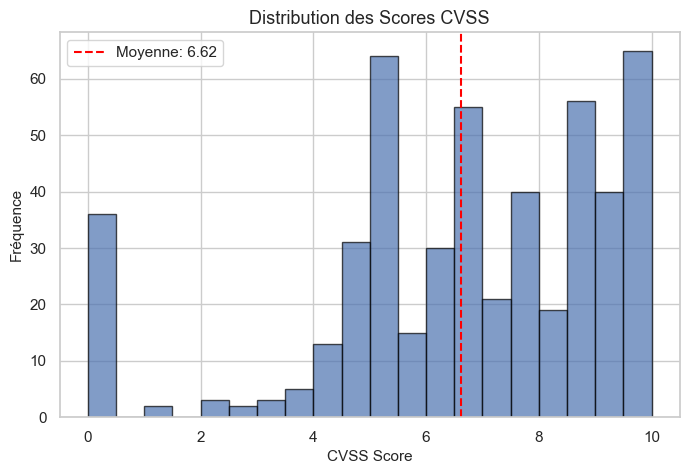


🏢 Top Vendors...


C:\Users\hamza\AppData\Local\Temp\ipykernel_2596\3339561476.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_vendors.values, y=top_vendors.index, palette='viridis')


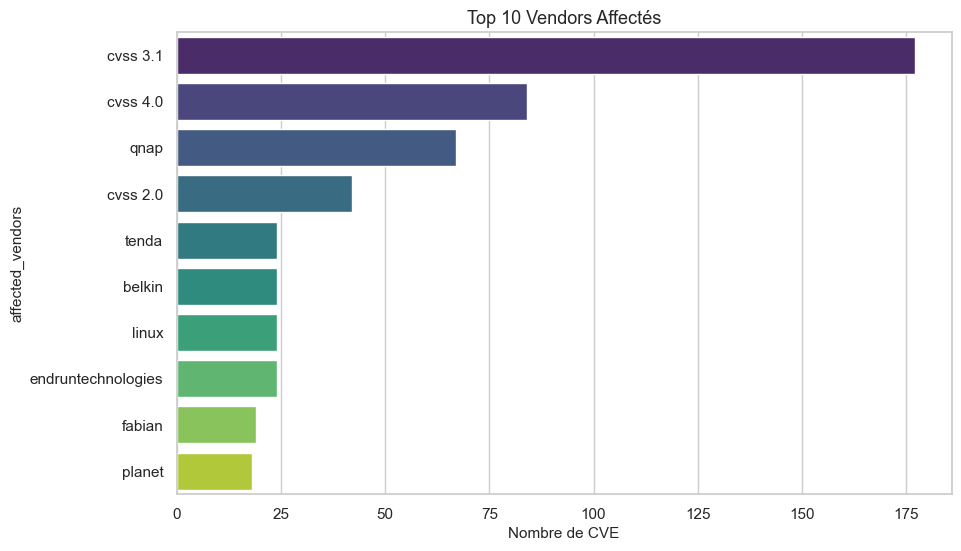

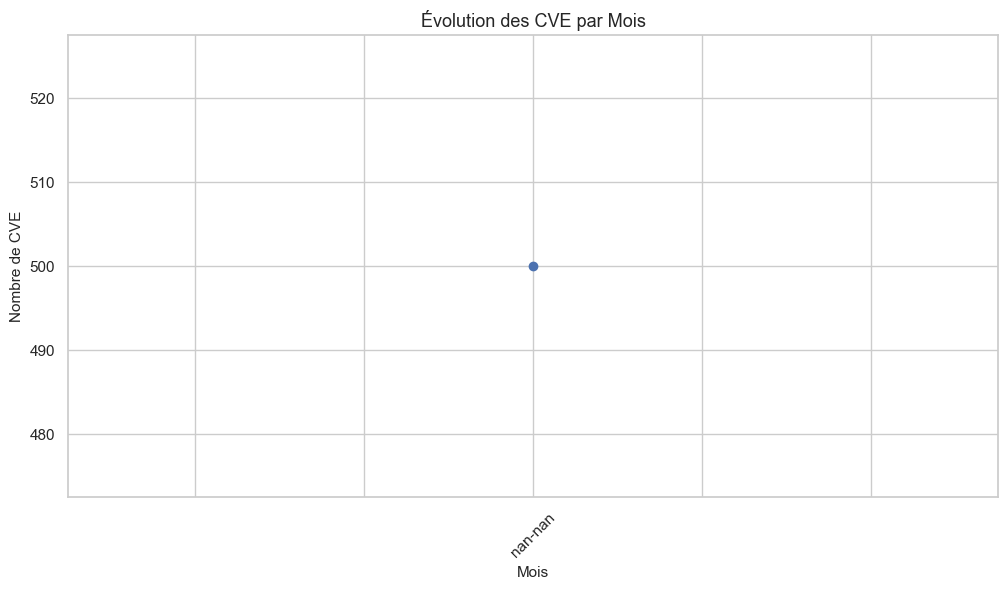

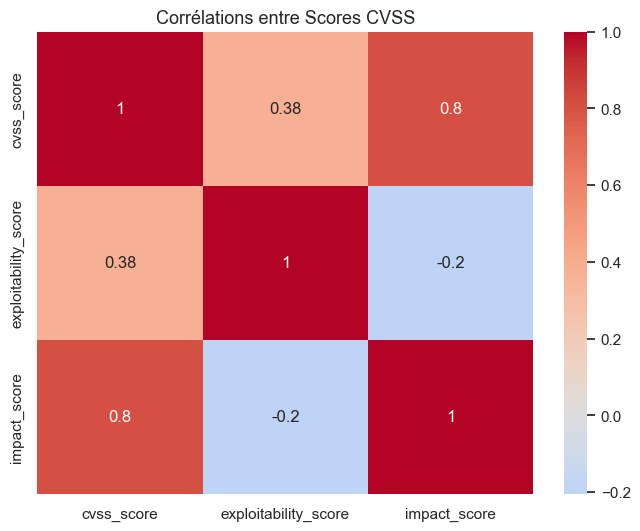

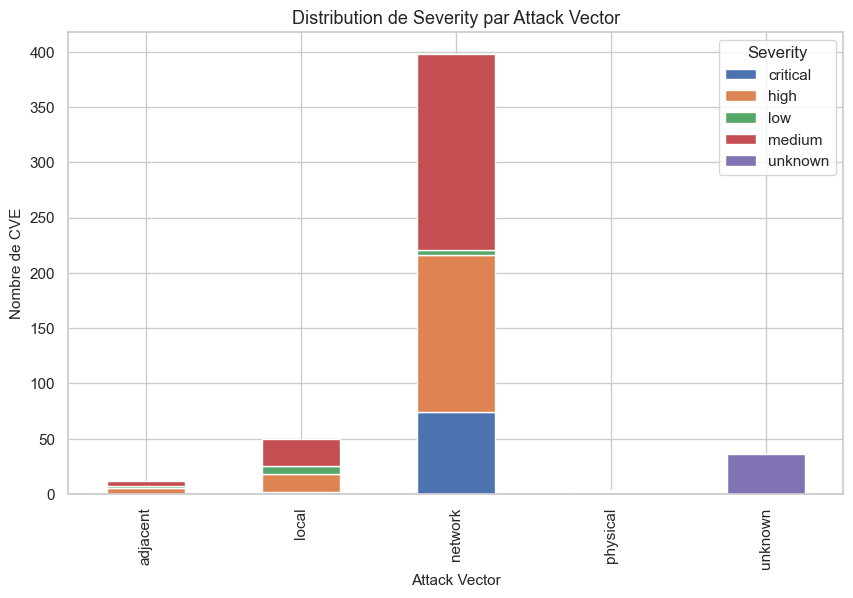

⚠️  wordcloud non installé — wordcloud sauté. Utilisez top TF-IDF de Bloc 6.

✅ Bloc 8 terminé ! Visualisations générées.


In [16]:
# ============================================================
# 🧩 Bloc 8 : Visualisations Exploratoires
# ============================================================

# --- 1️⃣ Histogramme du cvss_score
print("📈 Visualisations...")

if 'cvss_score' in df.columns:
    plt.figure(figsize=(8, 5))
    plt.hist(df['cvss_score'].dropna(), bins=20, edgecolor='black', alpha=0.7)
    plt.title('Distribution des Scores CVSS')
    plt.xlabel('CVSS Score')
    plt.ylabel('Fréquence')
    plt.axvline(df['cvss_score'].mean(), color='red', linestyle='--', label=f'Moyenne: {df["cvss_score"].mean():.2f}')
    plt.legend()
    plt.show()

# --- 2️⃣ Barplot top vendors (utiliser df_exploded_vendors si disponible)
print("\n🏢 Top Vendors...")
if 'df_exploded_vendors' in locals() and df_exploded_vendors is not None:
    top_vendors = df_exploded_vendors['affected_vendors'].value_counts().head(10)
    plt.figure(figsize=(10, 6))
    sns.barplot(x=top_vendors.values, y=top_vendors.index, palette='viridis')
    plt.title('Top 10 Vendors Affectés')
    plt.xlabel('Nombre de CVE')
    plt.show()
else:
    print("⚠️  df_exploded_vendors non disponible — barplot vendors sauté.")

# --- 3️⃣ Time Series : CVE par mois
if 'published_month' in df.columns and 'published_year' in df.columns:
    df['year_month'] = df['published_year'].astype(str) + '-' + df['published_month'].astype(str).str.zfill(2)
    monthly_counts = df['year_month'].value_counts().sort_index()
    
    plt.figure(figsize=(12, 6))
    monthly_counts.plot(kind='line', marker='o')
    plt.title('Évolution des CVE par Mois')
    plt.xlabel('Mois')
    plt.ylabel('Nombre de CVE')
    plt.xticks(rotation=45)
    plt.show()

# --- 4️⃣ Heatmap corrélations (scores)
numeric_features = ['cvss_score', 'exploitability_score', 'impact_score']
if all(col in df.columns for col in numeric_features):
    corr_matrix = df[numeric_features].corr()
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
    plt.title('Corrélations entre Scores CVSS')
    plt.show()

# --- 5️⃣ Barres empilées : attack_vector vs severity
if 'attack_vector' in df.columns and 'severity_label' in df.columns:
    pivot_table = df.groupby(['attack_vector', 'severity_label']).size().unstack(fill_value=0)
    pivot_table.plot(kind='bar', stacked=True, figsize=(10, 6))
    plt.title('Distribution de Severity par Attack Vector')
    plt.xlabel('Attack Vector')
    plt.ylabel('Nombre de CVE')
    plt.legend(title='Severity')
    plt.show()

# --- 6️⃣ Wordcloud simple pour description (nécessite wordcloud si installé, sinon TF-IDF top)
try:
    from wordcloud import WordCloud
    if 'description_clean' in df.columns:
        text = ' '.join(df['description_clean'].dropna())
        wc = WordCloud(width=800, height=400, background_color='white').generate(text)
        plt.figure(figsize=(10, 5))
        plt.imshow(wc, interpolation='bilinear')
        plt.axis('off')
        plt.title('Word Cloud des Descriptions')
        plt.show()
except ImportError:
    print("⚠️  wordcloud non installé — wordcloud sauté. Utilisez top TF-IDF de Bloc 6.")

print("\n✅ Bloc 8 terminé ! Visualisations générées.")

In [17]:
# ============================================================
# 🧩 Bloc 9 : Export du dataset traité et résumé final
# ============================================================

# --- 1️⃣ Sauvegarde des datasets
print("💾 Export des données traitées...")

# df original nettoyé
df_clean_path = "output/cve_detailed_clean.csv"
df.to_csv(df_clean_path, index=False, encoding='utf-8')
print(f"   → df (nettoyé) exporté : {df_clean_path}")

# df prêt pour ML
df_ml_path = "output/cve_detailed_ml_ready.csv"
df_scaled.to_csv(df_ml_path, index=False, encoding='utf-8')
print(f"   → df_scaled (ML-ready) exporté : {df_ml_path}")

# df explosé pour vendors (si disponible)
if 'df_exploded_vendors' in locals() and df_exploded_vendors is not None:
    exploded_path = "output/cve_exploded_vendors.csv"
    df_exploded_vendors.to_csv(exploded_path, index=False, encoding='utf-8')
    print(f"   → df_exploded_vendors exporté : {exploded_path}")

# --- 2️⃣ Rapport qualité final
print("\n📋 Rapport final :")

# Dimensions
print(f"   → Dataset final : {df.shape[0]} lignes × {df.shape[1]} colonnes")
print(f"   → Dataset ML : {df_scaled.shape[0]} lignes × {df_scaled.shape[1]} colonnes")

# Manquants restants
final_missing = df.isna().sum().sum()
print(f"   → Manquants restants dans df : {final_missing}")

# Distribution severity
print(f"   → Répartition Severity : {df['severity_label'].value_counts().to_dict()}")

# Top catégories
if 'category' in df.columns:
    print(f"   → Top 5 Catégories : {df['category'].value_counts().head().to_dict()}")

# Corrélations rapides
if all(col in df.columns for col in ['cvss_score', 'exploitability_score', 'impact_score']):
    print(f"   → Corr CVSS/Exploitability : {df['cvss_score'].corr(df['exploitability_score']):.3f}")

# --- 3️⃣ Sauvegarde du scaler et encoders (pour reproductibilité)
import joblib
joblib.dump(scaler, 'output/scaler_cvss.pkl')
if text_cols_for_ml:
    joblib.dump(tfidf, 'output/tfidf_description.pkl')
print("   → Scaler et TF-IDF sauvés (joblib).")

print("\n🎉 Projet EDA & Pré-traitement terminé ! Datasets prêts pour modélisation ou analyse avancée.")
print("\n💡 Prochaines étapes suggérées :")
print("   - Modélisation (classification severity, clustering produits)")
print("   - Topic modeling avancé (LDA sur descriptions)")
print("   - Dashboard interactif (Plotly Dash ou Streamlit)")

💾 Export des données traitées...
   → df (nettoyé) exporté : output/cve_detailed_clean.csv
   → df_scaled (ML-ready) exporté : output/cve_detailed_ml_ready.csv
   → df_exploded_vendors exporté : output/cve_exploded_vendors.csv

📋 Rapport final :
   → Dataset final : 500 lignes × 50 colonnes
   → Dataset ML : 500 lignes × 128 colonnes
   → Manquants restants dans df : 7762
   → Répartition Severity : {'medium': 208, 'high': 165, 'critical': 76, 'unknown': 36, 'low': 15}
   → Top 5 Catégories : {'injection': 138, 'memory corruption': 70, 'cross-site scripting': 66, 'denial of service': 43, 'authentication': 35}
   → Corr CVSS/Exploitability : 0.377
   → Scaler et TF-IDF sauvés (joblib).

🎉 Projet EDA & Pré-traitement terminé ! Datasets prêts pour modélisation ou analyse avancée.

💡 Prochaines étapes suggérées :
   - Modélisation (classification severity, clustering produits)
   - Topic modeling avancé (LDA sur descriptions)
   - Dashboard interactif (Plotly Dash ou Streamlit)
